In [1]:
import torch 
from torch import nn

from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torchvision.transforms as T

In [2]:
class celebData(Dataset):
    def __init__(self, image_dir, image_transform=None):
        self.image_dir = image_dir
        self.image_transform = image_transform
        self.image_paths = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.image_transform:
            image = self.image_transform(image)

        return image

In [3]:
image_dir = "img_align_celeba/img_align_celeba"
data = celebData(image_dir)

In [4]:
img = data[2]

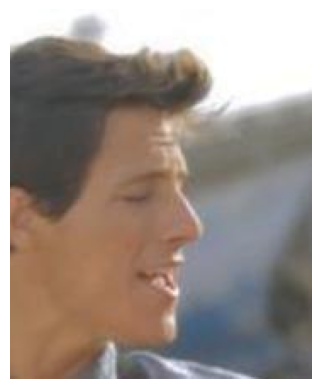

In [5]:
if hasattr(img, "permute"):
    img = img.permute(1, 2, 0).numpy()

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis("off")
plt.show()

In [6]:
image_transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])
train_dataset = celebData(
    image_dir="img_align_celeba/img_align_celeba",
    image_transform=image_transform
)

test_dataset = celebData(
    image_dir="test"
)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, shuffle=False)

In [8]:
len(train_dataset)

202599

In [9]:
len(train_loader)

3166

In [10]:
len(test_dataset)

20000

In [11]:
len(test_loader)

313

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()

        self.z_dim = z_dim

        self.g_net = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=1024*4*4),
            nn.Unflatten(1, (1024, 4, 4)),   # reshape to (1024,4,4)


            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.g_net(z)
        return out

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.d_net = nn.Sequential(

            # (3,64,64) -> (128,32,32)
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),    

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        out1 = self.d_net(img).view(-1, 1)
        return out1

In [14]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
gen = Generator(z_dim=100).to(device)
gen.apply(weights_init)

Generator(
  (g_net): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1024, 4, 4))
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): Tanh()
  )
)

In [17]:
z = torch.randn(1, 100, device=device)

In [18]:
fake_img = gen(z).detach().cpu()

In [19]:
disc = Discriminator().to(device)
disc.apply(weights_init)

Discriminator(
  (d_net): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [67]:
real_images = next(iter(train_loader))
real_images = real_images.to(device)
print(real_images.shape)

torch.Size([64, 3, 64, 64])


In [68]:
real_images.type()

'torch.cuda.FloatTensor'

In [69]:
real_loss = -(1*torch.log(disc(real_images)) + (1-1)*torch.log(1-disc(real_images)+ 1e-8)).mean()  # −logD(x)
# LD​=−(logD(x)+log(1−D(G(z)))) above is for y=1

In [71]:
# z = torch.randn(batch_size, latent_dim).to(device)
batch_size = real_images.size(0)
z = torch.randn(batch_size, gen.z_dim, device=device)  # [batch, 100]
fake_images = gen(z)
fake_images_reshaped = fake_images.view(-1, 3, 64, 64)

In [72]:
fake_images_reshaped.shape

torch.Size([64, 3, 64, 64])

In [73]:
print(fake_images.shape)
print(fake_images_reshaped.shape)

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


In [74]:
fake_loss = -(0*torch.log(disc(fake_images_reshaped)) + (1-0)*torch.log(1-disc(fake_images_reshaped)+ 1e-8)).mean()

In [75]:
d_loss = real_loss + fake_loss

In [76]:
d_loss

tensor(1.6250, device='cuda:0', grad_fn=<AddBackward0>)

In [77]:
d_loss.shape

torch.Size([])

In [78]:
# for the generator loss
# LG​=−log(D(G(z)))

In [18]:
g_loss = -(torch.log(disc(fake_images_reshaped)+ 1e-8)).mean()

NameError: name 'fake_images_reshaped' is not defined

In [21]:
batch_size = real_images.size(0)
batch_size

NameError: name 'real_images' is not defined

In [20]:
optimizer_D = torch.optim.Adam(disc.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0003, betas=(0.5, 0.999))

In [21]:
from tqdm.notebook import tqdm
import logging
from datetime import datetime
import torchvision.utils as vutils


# Create logs directory
os.makedirs("logs_gan", exist_ok=True)

save_dir = 'samples'
os.makedirs(save_dir, exist_ok=True)

# Timestamped log file
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_file = f"logs_gan/train_{timestamp}.log"


# Configure logging
logging.basicConfig(
    filename=log_file,
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Config
epochs = 50
batch_size = 64
checkpoint_path = "best_gan.pth"
best_loss = float('inf')
patience = 5
patience_counter = 0


logging.info(f'''Starting GAN training:
    Epochs:          {epochs}
    Batch size:      {batch_size}
    Learning rate:   {0.0002}
    Device:          {device}
    Beta1, Beta2:    (0.5, 0.999)
''')


# Resume training if checkpoint exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss_G']  # monitor generator loss
    logging.info(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0


fixed_noise = torch.randn(16, gen.z_dim, device=device)


for epoch in range(start_epoch, epochs):
    epoch_loss_d = 0.0
    epoch_loss_g = 0.0

    # Wrap train_loader with tqdm
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=True)
    
    for real_images in loop:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()


        # 🔹 Instance noise
        noise_std = 0.05
        real_noisy = real_images + noise_std * torch.randn_like(real_images)
        real_noisy = torch.clamp(real_noisy, 0.0, 1.0)


        z = torch.randn(batch_size, gen.z_dim, device=device)
        fake_images = gen(z).view(-1, 3, 64, 64)
        fake_noisy = fake_images.detach() + noise_std * torch.randn_like(fake_images)
        fake_noisy = torch.clamp(fake_noisy, 0.0, 1.0)


        # 🔹 Label smoothing (instead of 1.0 and 0.0)
        real_smooth = 0.9
        fake_smooth = 0.1

        # Real images → y = 1
        real_pred = disc(real_noisy)

        # Real images loss
        # real_loss = -(1*torch.log(real_pred+1e-8) + (1-1)*torch.log(1-real_pred+ 1e-8)).mean()  
        real_loss = -(real_smooth * torch.log(real_pred + 1e-8) + (1 - real_smooth) * torch.log(1 - real_pred + 1e-8)).mean()


        # batch_size = real_images.size(0)
        # z = torch.randn(batch_size, gen.z_dim, device=device)  # [batch, 100]
        # fake_images = gen(z)
        # fake_images_reshaped = fake_images.view(-1, 3, 64, 64)

        fake_pred = disc(fake_noisy.detach())
        # fake_loss = -(0*torch.log(fake_pred+1e-8) + (1-0)*torch.log(1-fake_pred+ 1e-8)).mean()
        fake_loss = -(fake_smooth * torch.log(fake_pred + 1e-8) + (1 - fake_smooth) * torch.log(1 - fake_pred + 1e-8)).mean()


        d_loss = real_loss + fake_loss
        
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # Generator tries to fool discriminator
        z = torch.randn(batch_size, gen.z_dim, device=device)   # new z sample
        fake_images = gen(z).view(-1, 3, 64, 64)
        fake_pred = disc(fake_images)
        g_loss = -(torch.log(fake_pred+ 1e-8)).mean()


        g_loss.backward()
        optimizer_G.step()

        epoch_loss_d = epoch_loss_d + d_loss.item()
        epoch_loss_g = epoch_loss_g + g_loss.item()

        # Update tqdm description with losses
        loop.set_postfix(D_loss=epoch_loss_d/(loop.n+1), G_loss=epoch_loss_g/(loop.n+1))

    avg_loss_d = epoch_loss_d / len(train_loader)
    avg_loss_g = epoch_loss_g / len(train_loader)

    logging.info(f"Epoch {epoch+1}: D Loss: {avg_loss_d:.4f}, G Loss: {avg_loss_g:.4f}")
    print(f"Epoch {epoch+1}/{epochs}, D Loss: {avg_loss_d:.4f}, G Loss: {avg_loss_g:.4f}")

    # save samples every 5 epochs
    if (epoch + 1) % 1 == 0:
        gen.eval()
        with torch.no_grad():
            fake_images = gen(fixed_noise).view(-1, 3, 64, 64)  # (N, 3, 64, 64)
        gen.train()
    
        # Normalize to [0,1] for saving
        fake_images = (fake_images + 1) / 2  # assuming output in [-1,1]
    
        vutils.save_image(fake_images, f"samples/fake_epoch_{epoch+1}.png",
                          nrow=4, normalize=True)
        logging.info(f"Saved sample images for epoch {epoch+1}")

    # --------------------------
    # Checkpoint + Early Stopping
    # --------------------------
    if avg_loss_g < best_loss:  # track generator loss
        best_loss = avg_loss_g
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'gen_state_dict': gen.state_dict(),
            'disc_state_dict': disc.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'loss_G': best_loss,
            'loss_D': avg_loss_d
        }, checkpoint_path)
        logging.info(f"Saved checkpoint at epoch {epoch+1} (G loss {best_loss:.6f})")
    else:
        patience_counter += 1
        logging.info(f"No improvement in G loss (patience {patience_counter}/{patience})")

    if patience_counter >= patience:
        logging.info(f"Early stopping at epoch {epoch+1}")
        print("Early stopping triggered")
        break

Epoch [3/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 3/50, D Loss: 0.6722, G Loss: 0.0167


Epoch [4/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 4/50, D Loss: 0.6635, G Loss: 0.0236


Epoch [5/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 5/50, D Loss: 0.6592, G Loss: 0.0061


Epoch [6/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 6/50, D Loss: 0.6567, G Loss: 0.0055


Epoch [7/50]:   0%|          | 0/3166 [00:00<?, ?it/s]

Epoch 7/50, D Loss: 0.6527, G Loss: 0.0001
Early stopping triggered


In [22]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained generator from the checkpoint
checkpoint_path = "best_gan3.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)  # Load to the correct device
    gen = Generator().to(device)  # Move model to device
    gen.load_state_dict(checkpoint['gen_state_dict'])
    gen.eval()
    print(f"Loaded generator from {checkpoint_path}")
else:
    print("Checkpoint not found. Please train the model first.")
    exit()

# Generate noise for new samples on the same device
batch_size = 4  # Number of images to generate
z_dim = 100     # Match your model's z_dim
fixed_noise = torch.randn(batch_size, z_dim, device=device)  # Noise on the same device

# Generate fake images
with torch.no_grad():
    fake_images = gen(fixed_noise).view(-1, 3, 64, 64)  # Adjust shape based on your model

# Normalize images to [0, 1] (assuming output is in [-1, 1])
fake_images = (fake_images + 1) / 2

# Display the generated images
plt.figure(figsize=(12, 3))
plt.imshow(vutils.make_grid(fake_images.cpu(), nrow=4, normalize=True).permute(1, 2, 0))  # Move to CPU for plotting
plt.axis("off")
plt.show()

# Optional: Save the generated images
save_dir = 'predictions'
os.makedirs(save_dir, exist_ok=True)
vutils.save_image(fake_images, f"{save_dir}/predicted_images.png", nrow=4, normalize=True)
print(f"Saved predicted images to {save_dir}/predicted_images.png")

Using device: cuda


RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "g_net.0.bias", "g_net.2.weight", "g_net.2.bias", "g_net.3.bias", "g_net.3.running_mean", "g_net.3.running_var", "g_net.5.weight", "g_net.5.bias", "g_net.6.bias", "g_net.6.running_mean", "g_net.6.running_var", "g_net.8.weight", "g_net.8.bias", "g_net.9.bias", "g_net.9.running_mean", "g_net.9.running_var", "g_net.11.weight", "g_net.11.bias". 
	Unexpected key(s) in state_dict: "g_net.1.weight", "g_net.1.bias", "g_net.1.running_mean", "g_net.1.running_var", "g_net.1.num_batches_tracked", "g_net.4.weight", "g_net.4.bias", "g_net.4.running_mean", "g_net.4.running_var", "g_net.4.num_batches_tracked", "g_net.7.weight", "g_net.7.bias", "g_net.7.running_mean", "g_net.7.running_var", "g_net.7.num_batches_tracked", "g_net.10.weight", "g_net.10.bias", "g_net.10.running_mean", "g_net.10.running_var", "g_net.10.num_batches_tracked", "g_net.12.weight". 
	size mismatch for g_net.0.weight: copying a param with shape torch.Size([100, 1024, 4, 4]) from checkpoint, the shape in current model is torch.Size([16384, 100]).
	size mismatch for g_net.3.weight: copying a param with shape torch.Size([1024, 512, 4, 4]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for g_net.6.weight: copying a param with shape torch.Size([512, 256, 4, 4]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for g_net.9.weight: copying a param with shape torch.Size([256, 128, 4, 4]) from checkpoint, the shape in current model is torch.Size([128]).